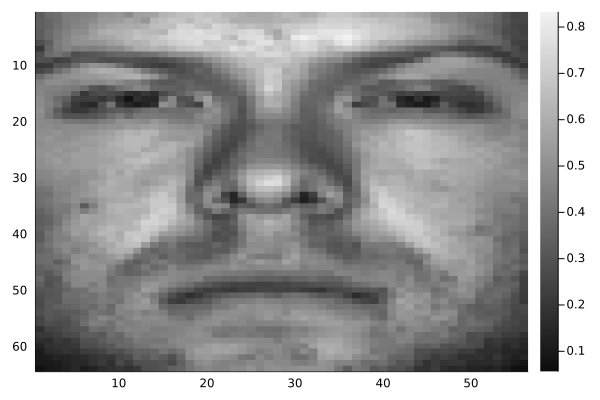

In [589]:
using Images
using ImageTransformations
using Interpolations
using LinearAlgebra
using Random, Distributions, StatsBase, Plots
rngSeed = Random.seed!(0)
dirFile = "/home/javiersc/Desktop/CroppedYale/yaleB01/"
f = open(string(dirFile,"yaleB01_P00.info"));
lines = readlines(f);
scaleFactor = 3
dataMatrix = zeros(round(Int,192*168/(scaleFactor^2)),length(lines))
i = 1
for l in lines
    img = load(string(dirFile, l))
    img = convert(Array{Float64}, img)
    σ = map((o,n) -> 0.75*o/n, size(img), ceil.(Int, size(img).*(1/scaleFactor)) )
    kern = KernelFactors.gaussian(σ)
    #img = imresize(imfilter(img,kern,NA()), ratio=1/scaleFactor, method=BSpline(Linear()))
    img = imresize(img, ratio=1/scaleFactor, method=BSpline(Linear()))
    dataMatrix[:,i] = vec(img)
    i += 1
end
permutationOrder = randperm(Random.seed!(0), size(dataMatrix)[2])
dataMatrix = dataMatrix[:,permutationOrder]
sampleMean = mean(dataMatrix,dims=2)
dataMatrix = dataMatrix .- sampleMean
 # David's SignFlip PA
σfs = [svdvals(rand([-1,1],size(dataMatrix)) .* dataMatrix) for _ in 1:5]
σfs = [getindex.(σfs,j) for j in 1:min(size(dataMatrix)[1], size(dataMatrix)[2])]
α = 0.95
rankLevel = findfirst(svdvals(dataMatrix) .<= quantile.(σfs,α)) - 1

U = svd(dataMatrix).U[:,1:rankLevel];
projectedMatrix = U*U'*dataMatrix;
Y = deepcopy(projectedMatrix)

goodSamples = 3
σ1 = 0.01
σ2 = 0.1
for i = 1:size(Y)[2]
    if (i <= goodSamples)
        Y[:,i] = Y[:,i] + rand(Normal(0,σ1), size(Y)[1])
    else
        Y[:,i] = Y[:,i] + rand(Normal(0,σ2), size(Y)[1])
    end
end

img = reshape(projectedMatrix[:,5]+sampleMean,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
heatmap(img, yflip=true, c=:grays)

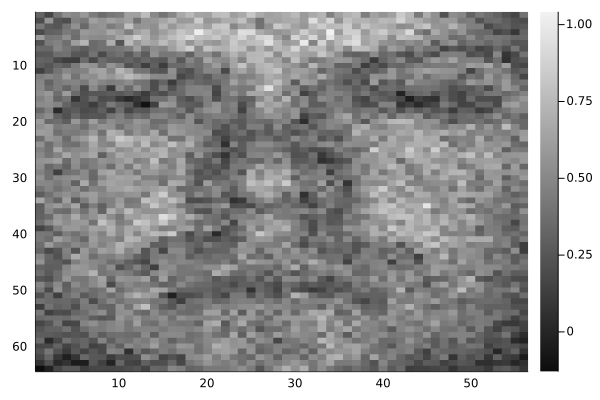

In [590]:
noisyimg = reshape(Y[:,5]+sampleMean,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
heatmap(noisyimg, yflip=true, c=:grays)

In [570]:
#Π_known = vcat(σ1^2 *ones(goodSamples), σ2^2 *ones(size(projectedMatrix)[2]-goodSamples))

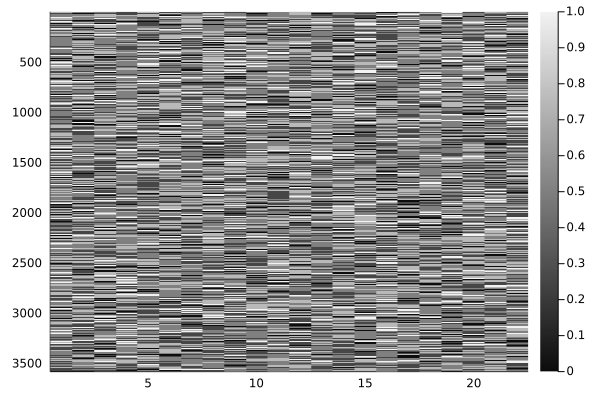

In [591]:
using Distributions
p = 0.5
M = rand(Bernoulli(p), size(Y))
Y_M = Y .* M;
imgCorrupted = reshape(Y_M[:,5]+sampleMean,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
#heatmap(imgCorrupted, yflip=true, c=:grays)
heatmap(M, yflip=true, c=:grays)

In [592]:
Π = diag((1/size(Y_M)[1])*(Y_M-projectedMatrix)'*(Y_M-projectedMatrix))
Π_known = zeros(size(Π))
Π_known[1:goodSamples] .= mean(Π[1:goodSamples])
Π_known[(goodSamples+1):end] .= mean(Π[(goodSamples+1):end]);
Π_known

22-element Vector{Float64}:
 0.005549785175487478
 0.005549785175487478
 0.005549785175487478
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128
 0.01126770513470128

In [593]:
include("pogm_restart.jl")

function op(X)
    return X .* M
end

function adjoint_op(X)
    return X #X .* M
end
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end

function HPCA_POGM(Y, λr,w, rankLevel, bound)
    Π = Diagonal(w.^-1)
    Lf = maximum(w.^-1)
    x0 = zeros(size(Y))
    grad = K -> -1*adjoint_op((Y-op(K))*Π)
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,rankLevel)
        U,S,V = svd(x)
        S[(rankLevel+1):end] = soft.(S[(rankLevel+1):end],t)
        return U*Diagonal(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, rankLevel)
    T, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=bound, mom=:fpgm, restart=:gr) # objective(x,Y-x,λr,w)
    #U = svd(T).U[:,1:rankLevel]
    return T
end

HPCA_POGM (generic function with 1 method)

In [594]:
U_WPCA = weightedPCA(Y_M,Π_known.^-1,rankLevel)
error_wpca = norm(U_WPCA*U_WPCA' - U*U', 2)/norm(U*U', 2)
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y_M[:,1:goodSamples])
push!(heppCAT_matrix, Y_M[:,(goodSamples+1):end])
homoPCA = heppcat(heppCAT_matrix,rankLevel,0)   # init is homoscedastic PPCA
error_homoppca = norm(homoPCA.U*homoPCA.U' - U*U', 2)/norm(U*U', 2)

0.8979098581663972

In [595]:
error_wpca

0.871425015748954

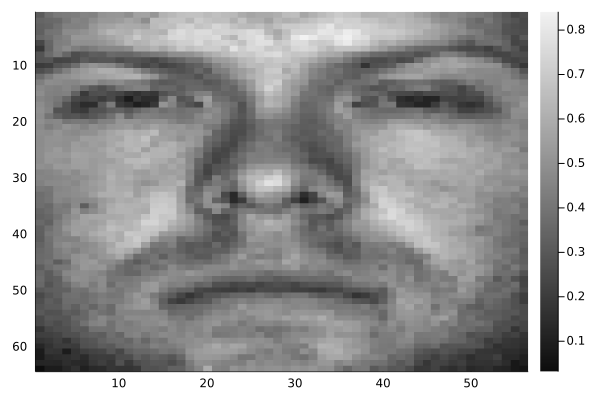

In [596]:
TEST = HPCA_POGM(Y_M, 10000, Π_known, rankLevel, 1e-6);
testImg = reshape(TEST[:,5]+sampleMean,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
heatmap(testImg, yflip=true, c=:grays)

In [597]:
using ImageQualityIndexes
assess_psnr(testImg, img)

36.3063483431561

In [598]:
assess_psnr(imgCorrupted, img)

22.650903560394184

In [599]:
newImg = U_WPCA*U_WPCA'*Y_M
newImg = reshape(newImg[:,5]+sampleMean, (round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
assess_psnr(newImg, img)

34.92711253062228

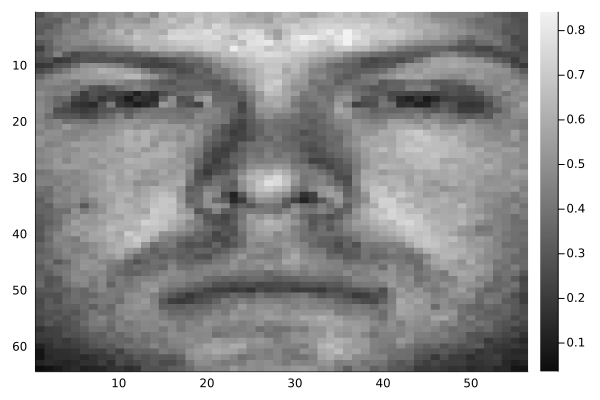

In [580]:
heatmap(newImg, yflip=true, c=:grays)

In [403]:
λr = vcat(1.0:10:100)
λr[1] = 0.001
error_hpca = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_POGM(Y_M, λr[i],Π_known, rankLevel, 1e-6) 
    error_hpca[i] = norm(U_HPCA*U_HPCA' - U*U',2)/norm(U*U',2)
end

1


LoadError: InterruptException:

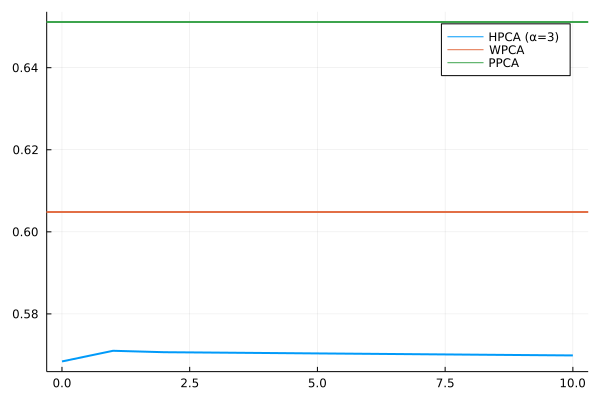

In [385]:
color_index = theme_palette(:auto).colors
using LaTeXStrings
plot(λr, error_hpca, label="HPCA (α=3)",linewidth=2)
hline!([error_wpca], label="WPCA", linewidth=2)
hline!([error_homoppca], label="PPCA", linewidth=2)

In [46]:
include("pogm_restart.jl")
function HPCA_POGM(Y, λr, w, N, ϵ)
    #objective = (X,Z,λr,Π) -> λr*nucnorm(X) + (1/2)*norm(Z*(Diagonal(Π.^-0.5)), 2)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    x0 = zeros(size(Y))
    #U = svd(Y).U[:,1:N]
    #x0 = U*U'*Y
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:pgm) # objective(x,Y-x,λr,w)
    return K
end
function AltMin(Y, λr, N, ϵ)
    U = svd(Y).U[:,1:N]
    #X = zeros(size(Y))
    X = U*U'*Y
    X0 = copy(X) .+ 1
    Π = W_NO_GROUPS(Y, X)
    #while norm(X-X0)/norm(X0) > ϵ
    for i = 1:4
        #println(norm(X-X0)/norm(X0))
        #flush(stdout)
        X0 = X
        X = HPCA_POGM(Y, λr, Π, 10, ϵ)
        Π = W_NO_GROUPS(Y, X)
    end
    return X
end
function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    Π = max.(Π,1e-9)
    return Π
end

W_NO_GROUPS (generic function with 1 method)

In [23]:
λr = vcat(0:0.1:1,1:0.5:10)
error_hpca_pogm = zeros(size(λr))
λr[1] = 0.001
for i=1:length(λr)
    println(i)
    flush(stdout)
    X_HPCA,_ = AltMin(Y, 4, Π_homo, 10, 1e-4)
    U_HPCA = svd(X_HPCA).U[:,1:10]
    error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

In [43]:
HPCA_POGM(Y, 20, ones(N), 10, 1e-4)

100×100 Matrix{Float64}:
 -20.7455    19.6103      6.56087    …   93.0553    -51.8568    -68.3275
  -5.93607   13.0431     -8.45638        -0.376219  -19.5514     27.1726
  -3.8904    -5.85741    -5.38835        14.0026    -51.1265    -32.1742
  16.8811   -18.447       0.505094       16.148      36.8805     23.0923
  -7.55951   22.2815     -2.73998       -34.5072     13.8995     39.7362
   2.76499    1.21233     0.0965487  …  -22.0896     -0.341536   81.8293
 -20.4022     6.89309   -16.2           -14.2954    -26.6141      7.0854
  26.5592    -6.47791     2.61863       -15.9353     10.4532    -24.8815
 -10.1082    12.1183    -14.7765        -45.7298    -28.2831      9.17305
  13.2482    -2.15289    24.0182          0.175731  -95.787      32.8691
   5.19754   -7.15664    -7.93142    …   67.4475    -23.3755    -28.1966
  -4.89169   10.0807    -15.3746        -58.577      -7.56053   -32.6184
 -13.9243    27.1977      3.15737       -11.5649     78.4691    -95.0404
   ⋮                     

In [44]:
AltMin(Y, 20, 10, 1e-4)

0.04128727857110637
0.2872296915923559
0.2358392422525838
0.19585567507575977
0.24205170687214952
0.4879710968885179
0.8942166568515804


LoadError: InterruptException: